In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk 
import string
import re
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image

nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Part 3 Twitter Data

In [ ]:
# load data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MIE1624_Group14/Course_Project/tweet_labeled.csv', encoding= 'unicode_escape')
df.head()

,Unnamed: 0,userid,location,tweetcreatedts,processed_text,label,pos,neg
0,0,2.679788e+09,"Vestal, NY",4/15/2022,french election marine le pen agenda sends shockwaves europe eu europe russia unity peace nato via,0,0.184749,0.815251
1,1,1.347160e+18,NaN,4/15/2022,let unite stop war ukraine let defend freedom save life ask world leader armukrainenow,0,0.168420,0.831580
2,2,4.124746e+08,Planet Earth,4/15/2022,want go ukraine hug elderly alone sadness despair written face everyone deserves kindness amp co...,0,0.027598,0.972402
3,3,2.725029e+08,Bilbao,4/15/2022,homeworkonlinehomework passive income money earn internet euro dollar stock exchange currency va...,0,0.223480,0.776520
4,4,6.201370e+08,"Washington, DC",4/15/2022,image ukraine exclusive content russiaukraine conflict subscribe cgtn,1,0.754868,0.245132


In [ ]:
df = df[df['processed_text'].notna()]

In [ ]:
# creating an instance of coiuntervectorizer
ct = CountVectorizer(max_df = 95, min_df=10)
dtm = ct.fit_transform(df['processed_text'])

# creating an instance for LDA and fit the sparse matrix 
LDA = LatentDirichletAllocation(n_components=5, random_state=101, learning_method='online')
LDA.fit(dtm)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=101)

In [ ]:
for i, topic in enumerate(LDA.components_):
  print(f'Top 15 words in topic {i}')
  print([ct.get_feature_names()[i] for i in topic.argsort()[-25:]])
  print('\n')

Top 15 words in topic 0
['head', 'kalush', 'body', 'nft', 'winning', 'doj', 'total', 'conflict', 'market', 'criminal', 'visit', 'october', 'stay', 'man', 'rest', 'playing', 'share', 'bitcoin', 'ukrainewillwin', 'citizen', 'nation', 'crypto', 'international', 'system', 'former']


Top 15 words in topic 1
['start', 'story', 'hospital', 'finland', 'sent', 'forever', 'else', 'ago', 'got', 'place', 'behind', 'afghanistan', 'space', 'slavaukrani', 'crew', 'oil', 'price', 'poland', 'matter', 'hope', 'truth', 'minister', 'already', 'covid', 'hearing']


Top 15 words in topic 2
['everything', 'trying', 'important', 'party', 'used', 'ftx', 'article', 'ww', 'pay', 'follow', 'long', 'gop', 'electionday', 'gasoil', 'infanticide', 'ukraineunderatta', 'member', 'atacms', 'around', 'iran', 'anti', 'sick', 'election', 'month', 'fascism']


Top 15 words in topic 3
['breakingnews', 'animal', 'chinese', 'black', 'supporting', 'product', 'put', 'slava', 'line', 'mean', 'thats', 'continue', 'enemy', 'nation

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
topic_map = {0:"Economic", 1:"Health", 2:"Geopolitics", 3: "War", 4:"Election"}
assigned_topics = LDA.transform(dtm)
assigned_topics.argmax(axis=1)
df['topic'] = assigned_topics.argmax(axis=1)
df["topic_name"] = df['topic'].map(topic_map)

In [ ]:
for i, topic in enumerate(LDA.components_):
  print(topic)
  print('\n')

[11.35156174  0.20091592 19.77647122 ...  0.2056443  50.41436147
  0.20329657]


[ 0.20461259 15.37223601  0.20917063 ...  0.20345099  0.20374848
  0.2009843 ]


[0.20268968 0.2046309  0.20339995 ... 0.20240019 0.20351061 0.20071062]


[0.20310258 0.20910048 0.20406565 ... 0.20060198 0.2018643  0.20084929]


[ 0.2020622   7.30359746  0.20418742 ... 13.05409292 18.63670254
 12.90326765]




## Filtering out positive and negative sentiments

In [ ]:
df_first4 = df[df['tweetcreatedts'].isin(['4/15/2022', '5/15/2022', '6/15/2022', '7/15/2022'])]
df_last4 = df[df['tweetcreatedts'].isin(['8/15/2022', '9/15/2022', '10/15/2022', '11/15/2022'])]

In [ ]:
# From part 2 results, label -1 means neutral, 0 means negative, and 1 means positive

# Creating dfs containing only positives and negatives
df_orig_positive = df[df['label']==1]
df_orig_negative = df[df['label']==0]

df_first4_positive = df_first4[df_first4['label']==1]
df_first4_negative = df_first4[df_first4['label']==0]

df_last4_positive = df_last4[df_last4['label']==1]
df_last4_negative = df_last4[df_last4['label']==0]

## Frequency Distributions and Word Cloud Creations

In [ ]:
# Frequency Distributions
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Creating a function for word cloud creation for the dataframes with lemmatization.
from nltk.stem import WordNetLemmatizer
def create_word_cloud(df):
    wordnet_lem = WordNetLemmatizer()
    df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)
    all_words_lem = ' '.join([word for word in df['text_string_lem']])
    wordcloud = WordCloud(max_font_size = 50, max_words = 500, random_state = 101).generate(all_words_lem)
    plt.figure(dpi = 700, figsize=(10,7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('Word Cloud')
    plt.show()

In [ ]:
# Creating a function for word frequency chart creations
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import seaborn as sns

def create_word_freq_chart(df):
    wordnet_lem = WordNetLemmatizer()
    df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)
    all_words_lem = ' '.join([word for word in df['text_string_lem']])
    words = nltk.word_tokenize(all_words_lem)
    fd = FreqDist(words)
    # Obtain top 20 words
    top_20 = fd.most_common(20)
    # Create pandas series to make plotting easier
    fdist = pd.Series(dict(top_20))
    sns.set_theme(style="ticks")
    sns.barplot(y=fdist.index, x=fdist.values, color='blue')

## Creating Word Clouds for the positive and negative results for whole dataset, first 4 months, and last 4 months

In [ ]:
create_word_cloud(df_orig_positive)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
create_word_cloud(df_orig_negative)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
create_word_cloud(df_first4_positive)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
create_word_cloud(df_first4_negative)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
create_word_cloud(df_last4_positive)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
create_word_cloud(df_last4_negative)

Output hidden; open in https://colab.research.google.com to view.

## Creating Frequency Distribution plots

<ipython-input-13-89826264b8e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


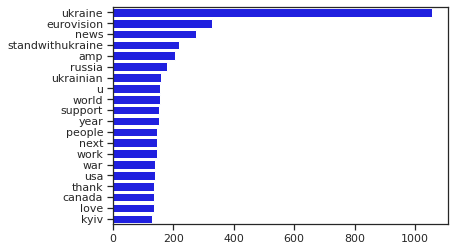

In [ ]:
create_word_freq_chart(df_orig_positive)

<ipython-input-13-89826264b8e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


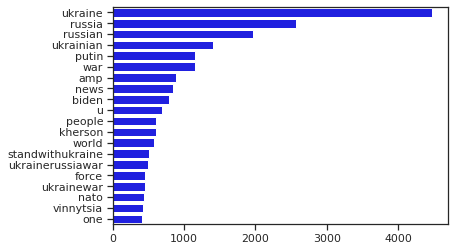

In [ ]:
create_word_freq_chart(df_orig_negative)

<ipython-input-13-89826264b8e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


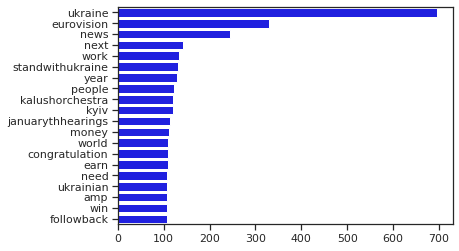

In [ ]:
create_word_freq_chart(df_first4_positive)

<ipython-input-13-89826264b8e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


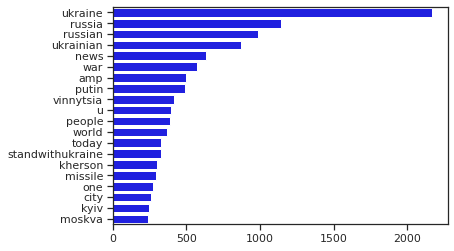

In [ ]:
create_word_freq_chart(df_first4_negative)

<ipython-input-13-89826264b8e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


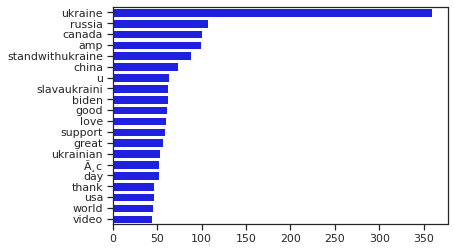

In [ ]:
create_word_freq_chart(df_last4_positive)

<ipython-input-13-89826264b8e4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


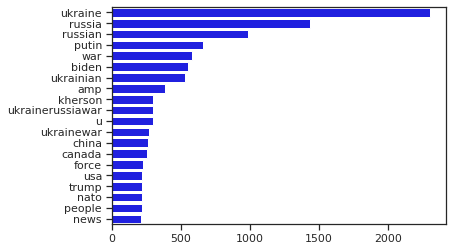

In [ ]:
create_word_freq_chart(df_last4_negative)

Initial thoughts:
standwithukraine: slogan for supporting ukraine 
russiaisaterroriststate: disagreeing with russia

## Removing obvious words related to the war: war, ukraine, russia, ukrainian, russian

In [ ]:
# Try removing the words that don't help the analysis: Russia, Ukraine, Russian, Ukrainian, war, etc
def create_word_freq_chart_remove(df):
    wordnet_lem = WordNetLemmatizer()
    df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)
    all_words_lem = ' '.join([word for word in df['text_string_lem']])
    all_words_lem = all_words_lem.replace('russia','')
    all_words_lem = all_words_lem.replace('ukraine','')
    all_words_lem = all_words_lem.replace('russian','')
    all_words_lem = all_words_lem.replace('ukrainian','')
    all_words_lem = all_words_lem.replace('war','')
    words = nltk.word_tokenize(all_words_lem)
    fd = FreqDist(words)
    # Obtain top 20 words
    top_20 = fd.most_common(20)
    # Create pandas series to make plotting easier
    fdist = pd.Series(dict(top_20))
    sns.set_theme(style="ticks")
    sns.barplot(y=fdist.index, x=fdist.values, color='blue')

<ipython-input-26-6e0eb3b380bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


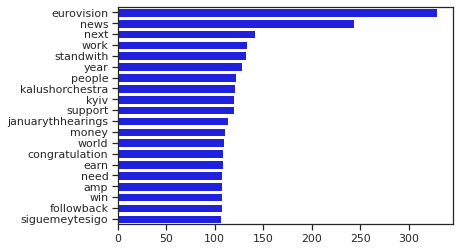

In [ ]:
# See if there's any changes to the word frequency distribution
create_word_freq_chart_remove(df_first4_positive)

<ipython-input-26-6e0eb3b380bc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)


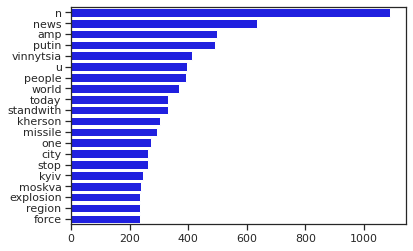

In [ ]:
create_word_freq_chart_remove(df_first4_negative)

## Top topics that drives sentiment

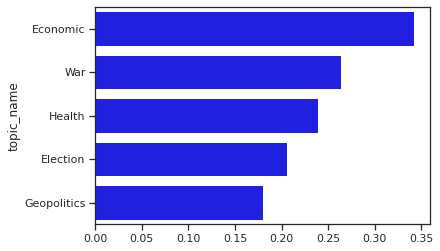

In [ ]:
# positive score
mean_scores = df.groupby("topic_name").mean()["pos"].sort_values(ascending=False)
sns.set_theme(style="ticks")
sns.barplot(y=mean_scores.index, x=mean_scores.values, color='blue')

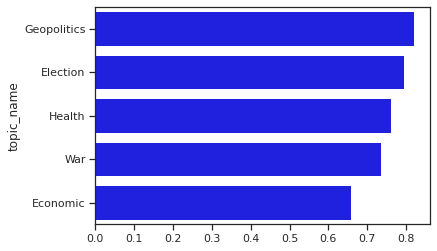

In [ ]:
# negative score
mean_scores = df.groupby("topic_name").mean()["neg"].sort_values(ascending=False)
sns.set_theme(style="ticks")
sns.barplot(y=mean_scores.index, x=mean_scores.values, color='blue')

## Tweet word count vs sentiment

In [ ]:
# count words in tweet
word_count = []
for text in df["processed_text"]:
  word_count.append(len(text.split()))
df["word_count"] = word_count


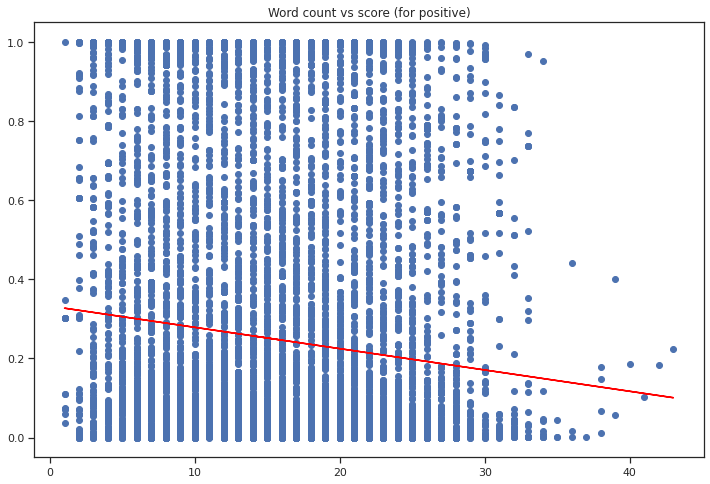

In [ ]:
x, y = df['word_count'].values.reshape(-1, 1), df["pos"].values.reshape(-1, 1)
# fit a liner regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


plt.figure(figsize=(12,8))
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.title("Word count vs score (for positive)")
plt.show()

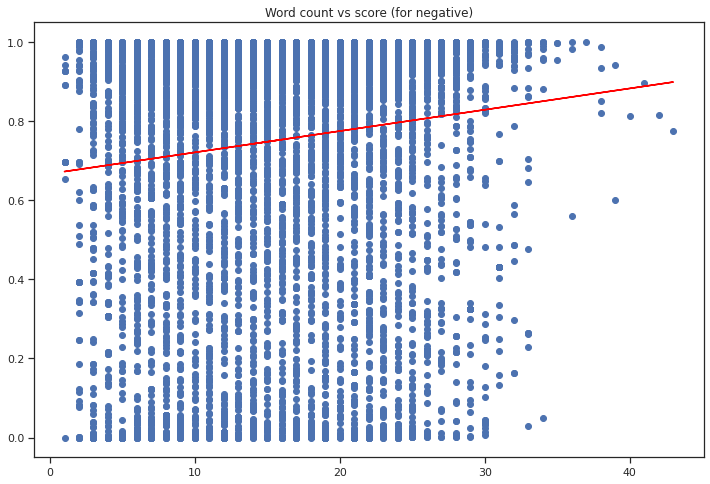

In [ ]:
x, y = df['word_count'].values.reshape(-1, 1), df["neg"].values.reshape(-1, 1)
# fit a liner regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


plt.figure(figsize=(12,8))
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.title("Word count vs score (for negative)")
plt.show()

Word count is a main factor of sentiment. Higher word count will lead to less positive and more positive sentiment

# Part 3 Reddit

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MIE1624_Group14/Course_Project/reddit_labeled.csv', encoding= 'unicode_escape')

In [ ]:
# df = pd.read_csv('reddit.csv', encoding= 'unicode_escape')

In [ ]:
df.head()

,Unnamed: 0,reddit,id,processed_reddit,label,pos,neg
0,0,Subscribe to r/RussiaUKraineWar2022 on Telegram for the fastest updates and more unseen footage....,v0gm37,subscribe rrussiaukrainewar telegram fastest update unseen footage,1,0.829609,0.170391
1,1,"10,000 servicemen of the second wave from training in UK are returning to Ukraine",y26xch,serviceman second wave training uk returning ukraine,0,0.277929,0.722071
2,2,r/RussiaUkraineWar2022 Predictions Tournament,ueslps,rrussiaukrainewar prediction tournament,1,0.838708,0.161292
3,3,"I'm safe, fifteen hours with a shovel in my hands and I have my own little house",y39tem,im safe fifteen hour shovel hand little house,0,0.263279,0.736721
4,4,this is my shell. there are many like it. but this one is mine.,y3hhep,shell many like one mine,0,0.152612,0.847388


In [ ]:
df.columns

Index(['Unnamed: 0', 'reddit', 'id', 'processed_reddit', 'label', 'pos',
       'neg'],
      dtype='object')

In [ ]:
df.shape

(872, 7)

## Topic Detection

In [ ]:
# creating an instance of coiuntervectorizer
ct = CountVectorizer(max_df = 95, min_df=10)
dtm = ct.fit_transform(df['processed_reddit'])

In [ ]:
# creating an instance for LDA and fit the sparse matrix 
LDA = LatentDirichletAllocation(n_components=5, random_state=101, learning_method='online')
LDA.fit(dtm)

LatentDirichletAllocation(learning_method='online', n_components=5,
                          random_state=101)

In [ ]:
# top 15
for i, topic in enumerate(LDA.components_):
  print(f'Top 15 words in topic {i}')
  print([ct.get_feature_names()[i] for i in topic.argsort()[-25:]])
  print('\n')

Top 15 words in topic 0
['footage', 'land', 'strike', 'near', 'lyman', 'training', 'equipment', 'shell', 'morning', 'belarus', 'minister', 'system', 'howitzer', 'combat', 'piece', 'mm', 'donetsk', 'new', 'operation', 'war', 'troop', 'defense', 'target', 'military', 'artillery']


Top 15 words in topic 1
['photo', 'russia', 'kharkiv', 'invader', 'counteroffensive', 'direction', 'unit', 'team', 'trooper', 'kerch', 'people', 'right', 'explosion', 'day', 'said', 'area', 'footage', 'blast', 'recently', 'serviceman', 'another', 'one', 'today', 'crimean', 'bridge']


Top 15 words in topic 2
['civilian', 'alert', 'move', 'using', 'missile', 'photo', 'nsfw', 'abandoned', 'armored', 'two', 'destroyed', 'army', 'body', 'fighting', 'first', 'legion', 'putin', 'drone', 'strike', 'vehicle', 'kyiv', 'captured', 'russia', 'oblast', 'kherson']


Top 15 words in topic 3
['footage', 'luhansk', 'military', 'round', 'attack', 'strike', 'zaporizhzhia', 'confirmed', 'battle', 'active', 'man', 'crimea', 'rece

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Assigning Topics

In [ ]:
df_orig = df.copy()

In [ ]:
topic_map = {0:"Politics", 1:"War_Footage", 2:"Military", 3: "Geography", 4:"Geopolitics"}
assigned_topics = LDA.transform(dtm)
assigned_topics.argmax(axis=1)
df_orig['topic'] = assigned_topics.argmax(axis=1)
df_orig["topic_name"] = df_orig['topic'].map(topic_map)

## Filtering out postive and negative sentiments

In [ ]:
df_orig_positive = df_orig[df_orig['label']==1]
df_orig_negative = df_orig[df_orig['label']==0]

## Frequency Distributions and Word Cloud Creations



In [ ]:
# Frequency Distributions
nltk.download('punkt')

# Creating a function for word cloud creation for the dataframes with lemmatization.
from nltk.stem import WordNetLemmatizer
def create_word_cloud(df):
    wordnet_lem = WordNetLemmatizer()
    df['text_string_lem'] = df['processed_reddit'].apply(wordnet_lem.lemmatize)
    all_words_lem = ' '.join([word for word in df['text_string_lem']])
    wordcloud = WordCloud(max_font_size = 50, max_words = 500, random_state = 101).generate(str(all_words_lem))
    plt.figure(dpi = 700, figsize=(10,7))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.title('Word Cloud')
    plt.show()

# Creating a function for word frequency chart creations
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import seaborn as sns

def create_word_freq_chart(df):
    wordnet_lem = WordNetLemmatizer()
    df['text_string_lem'] = df['processed_reddit'].apply(wordnet_lem.lemmatize)
    all_words_lem = ' '.join([word for word in df['text_string_lem']])
    words = nltk.word_tokenize(all_words_lem)
    fd = FreqDist(words)
    # Obtain top 20 words
    top_20 = fd.most_common(20)
    # Create pandas series to make plotting easier
    fdist = pd.Series(dict(top_20))
    sns.set_theme(style="ticks")
    sns.barplot(y=fdist.index, x=fdist.values, color='blue')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
create_word_cloud(df_orig_positive)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
create_word_cloud(df_orig_negative)

Output hidden; open in https://colab.research.google.com to view.

<ipython-input-46-308efd66f6a0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_reddit'].apply(wordnet_lem.lemmatize)


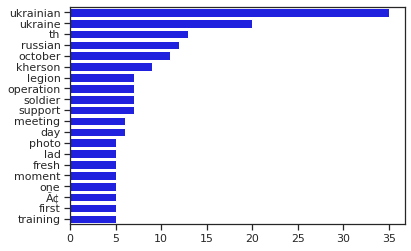

In [ ]:
create_word_freq_chart(df_orig_positive)

<ipython-input-46-308efd66f6a0>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text_string_lem'] = df['processed_reddit'].apply(wordnet_lem.lemmatize)


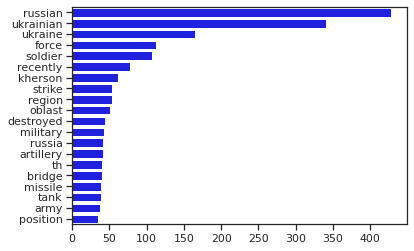

In [ ]:
create_word_freq_chart(df_orig_negative)

## Top Topics that drives sentiment

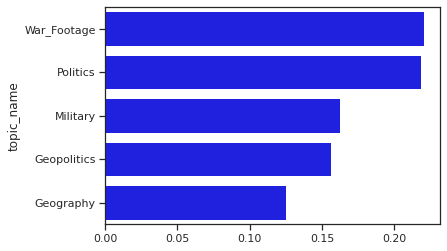

In [ ]:
# postive score vs topic
mean_scores = df_orig.groupby("topic_name").mean()["pos"].sort_values(ascending=False)
sns.set_theme(style="ticks")
sns.barplot(y=mean_scores.index, x=mean_scores.values, color='blue')

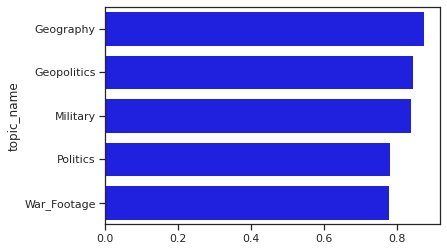

In [ ]:
# negative score vs topic
mean_scores = df_orig.groupby("topic_name").mean()["neg"].sort_values(ascending=False)
sns.set_theme(style="ticks")
sns.barplot(y=mean_scores.index, x=mean_scores.values, color='blue')

## Reddit word count vs sentiment

In [ ]:
# count words in tweet
word_count = []
for text in df_orig["processed_reddit"]:
  word_count.append(len(text.split()))
df_orig["word_count"] = word_count

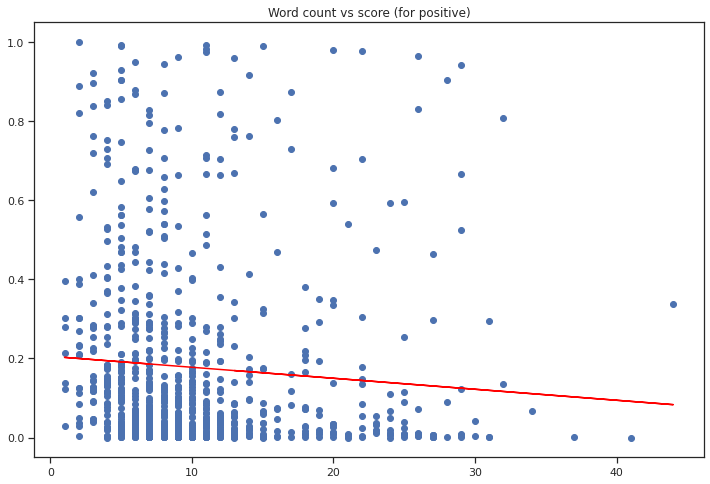

In [ ]:
x, y = df_orig['word_count'].values.reshape(-1, 1), df_orig["pos"].values.reshape(-1, 1)
# fit a liner regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


plt.figure(figsize=(12,8))
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.title("Word count vs score (for positive)")
plt.show()

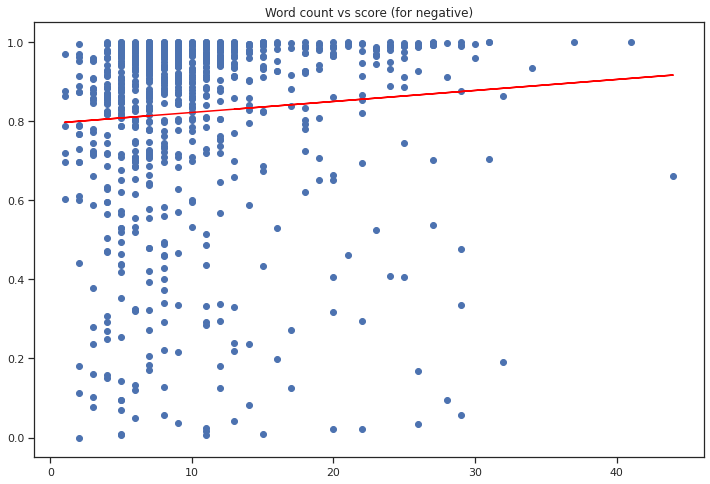

In [ ]:
x, y = df_orig['word_count'].values.reshape(-1, 1), df_orig["neg"].values.reshape(-1, 1)
# fit a liner regression model
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)
y_pred = model.predict(x)


plt.figure(figsize=(12,8))
plt.scatter(x, y)
plt.plot(x, y_pred, color='red')
plt.title("Word count vs score (for negative)")
plt.show()